In [226]:
import numpy as np
import torch.nn
import math
import os
import pandas as pd
import matplotlib.pyplot as plt

from citylearn.citylearn import CityLearnEnv
import citylearn
from citylearn.energy_model import HeatPump
from citylearn.utilities import read_json

import gym

import gym
from gym.spaces import Box
from stable_baselines3 import PPO, A2C, DDPG, TD3, SAC

from sb3_contrib.common.maskable.policies import MaskableActorCriticPolicy
from sb3_contrib.common.wrappers import ActionMasker
from sb3_contrib.ppo_mask import MaskablePPO
from sb3_contrib.common.maskable.utils import get_action_masks

In [2]:
def action_space_to_dict(aspace):
    """ Only for box space """
    return { "high": aspace.high,
             "low": aspace.low,
             "shape": aspace.shape,
             "dtype": str(aspace.dtype)
    }

def env_reset(env):
    observations = env.reset()
    action_space = env.action_space
    observation_space = env.observation_space
    building_info = env.get_building_information()
    building_info = list(building_info)
    action_space_dicts = [action_space_to_dict(asp) for asp in action_space]
    observation_space_dicts = [action_space_to_dict(osp) for osp in observation_space]
    obs_dict = {"action_space": action_space_dicts,
                "observation_space": observation_space_dicts,
                "building_info": building_info,
                "observation": observations }
    return obs_dict

In [3]:
from citylearn.utilities import read_json

schema_filepath = 'schema2.json'
schema = read_json(schema_filepath)
schema['root_directory'] = './'

env = CityLearnEnv(schema)
print(len(env.buildings))
print(env.action_space)

1
[Box([-0.71428573], [0.71428573], (1,), float32)]


In [4]:
schema_filepath = 'schema2.json'
schema = read_json(schema_filepath)
schema['root_directory'] = './'
env = CityLearnEnv(schema)
# env = EnvCityGym(env, devices=[['battery']], discrete=False, custom_reward=False,
#                 sum_cost=True, cost_ESU=True, zeta=0.1, stop=8760)
_ = env.reset()

In [5]:
class BuildingDevices:
  """
    Keeps track of all storage devices of a building.
  """
  def __init__(self, building, num_building):
    self.num_building = num_building
    self.building = building
    self.devices = {'battery' : Device_(building.electrical_storage, 'battery'),
                    'cooling' : None,
                    'dhw' : None}
    
  def compute_bounds(self):
    bounds = [self.bounds_action(i) for i,j in self.devices.items() if j is not None]
    return gym.spaces.Box(low=np.array([i[0] for i in bounds]), high=np.array([i[1] for i in bounds]), dtype=np.float64)
  
# ACTION 0 :  cooling
# ACTION 1 : dhw
# ACTION 2 : battery
  
  def bounds_action(self, type_action):
    device = self.devices[type_action].device
    if device is None:
        return None # if return none building doest have battery
    if type_action == 'battery':
        capacity = device.capacity_history[-2] if len(device.capacity_history) > 1 else device.capacity
        #HIGH
        #get max energy that the storage unit can use to charge [kW]
        #if trying to put more than the battery can accept reject action
        high1 = device.get_max_input_power()/capacity
        high2 = (device.capacity - device.soc_init)/(0.95*device.capacity) #approxim (efficiency = 0.95)
        high = min(high1, high2, 1)

        #LOW
        low1 = -device.get_max_input_power()/capacity
        low2 = (-device.soc_init*0.95)/device.capacity #approxim (efficiency = 0.95)
        low = max(low1, low2, -1)

    else:
        bool_h2, bool_l2 = False, False
        if type_action == 'cooling':
            # print('\ncooling')
            space_demand = self.building.cooling_demand[self.building.time_step]
            max_output = self.building.cooling_device.get_max_output_power(self.building.weather.outdoor_dry_bulb_temperature[self.building.time_step], False)
            # print('space_demand',space_demand)
            # print('max_output', max_output)
            # print('capacity:', device.capacity)
        else: #dhw
            # print('\ndhw')
            space_demand = self.building.dhw_demand[self.building.time_step]
            max_output = self.building.dhw_device.get_max_output_power(self.building.weather.outdoor_dry_bulb_temperature[self.building.time_step], False)\
            if isinstance(self.building.dhw_device, HeatPump) else self.building.dhw_device.get_max_output_power()
            # print('space_demand',space_demand)
            # print('max_output', max_output)
        space_demand = 0 if space_demand is None or math.isnan(space_demand) else space_demand # case where space demand is unknown

        #HIGH
        high1 = (max_output-space_demand) / device.capacity
        # print('high1', high1)
        if device.max_input_power is not None:
            bool_h2 = True
            high2 = device.max_input_power / device.capacity
            # print('high2', high2)
        high3 = (device.capacity - device.soc_init) / (device.capacity*device.efficiency)
        # print(device.capacity, device.soc_init)
        # print('high3', high3)
        
        if bool_h2:
            high = min(high1, high2, high3, 0.5)
        else:
            high = min(high1, high3, 0.5)


        #LOW
        low1 = -space_demand / device.capacity
        # print('low1', low1)
        if device.max_output_power is not None:
            bool_l2 = True
            low2 = -device.max_output_power / device.capacity
            # print('low2',low2)
        low3 = (-device.soc_init*device.efficiency) / device.capacity
        # print('low3',low3)

        if bool_l2:
            low = max(low1, low2, low3, -0.5)
        else:
            low = max(low1, low3, -0.5)

    return (low, high)

In [6]:
class Device_:
  def __init__(self, device, storage_type):
    self.device = device
    # self.price_cost = 0
    # self.emission_cost = 0
    self.cost = 0
    self.storage_type = storage_type

  def loss(self, cost_t, pv_offset, battery_offset):
    """
    get avg price between (battery release, grid release and PV- direct consumption)
    add relative incertainty, but true in pratice as the energy is added up in a global consumption pool 

    battery: if battery releases, price = avg((total released by battery - remaining conso), grid) in the case of thermal
    in the case of battery, avg price with PV
    """
    if not self.device:
      print('not device')
      raise ValueError

    energy_used = self.device.energy_balance[-1]
    if isinstance(energy_used, np.ndarray):
      print('probleme energy used array instead of float')
      energy_used = energy_used[0]

    #charge
    if energy_used > 0:
      #if pv production, part of the energy is free
      if pv_offset > 0:
        energy_used = max(0, energy_used-pv_offset)
      #if usage of battery, part of energy has been already taken into account so free
      if battery_offset > 0:
        energy_used = max(0, energy_used-battery_offset)
      # self.price_cost = ((self.price_cost*self.device.soc[-2])+(energy_used*price))/self.device.soc[-1]
      # self.emission_cost = ((self.emission_cost*self.device.soc[-2])+(energy_used*emission))/self.device.soc[-1]
      
      total = self.device.soc[-1]
      if isinstance(total, np.ndarray):
        print('probleme soc-1 array instead of float')
        total = total[0]

      prev = self.device.soc[-2]
      if isinstance(prev, np.ndarray):
        print('probleme soc-2 array instead of float')
        prev = prev[0]

      self.cost = ((self.cost*prev) + (energy_used*cost_t)) / total
      return energy_used, None, None #energy_used > 0

    #discharge
    else:
      #energy_processed is total energy used during charge/discharge process including losses
      #energy_used is the energy_processed minus the losses (used by building)
      energy_processed = self.device.soc[-2]-self.device.soc[-1]
      return -energy_used, energy_processed, self.cost # -energy_used > 0, energy_processed > 0 

In [7]:
def get_offset(building, mode):
  """
  building is env.buildings[i]:
  mode = 'pv' or 'battery'

  each conso gets an equally distributed offset based on solar generation or battery
  discharge
  """
  if mode == 'pv':
    if not building.solar_generation is None:
      return 0
    demands = [building.non_shiftable_load_demand[-2], building.electrical_storage.energy_balance[-1],
             building.dhw_demand[-2], building.dhw_storage.energy_balance[-1],
             building.cooling_demand[-2], building.cooling_storage.energy_balance[-1]]
    count = len([i for i in demands if i > 0])
    return -building.solar_generation[-2]/count
  else:
    if not building.solar_generation is None:
      return 0
    if building.electrical_storage.energy_balance[-1] >=0:
      return 0
    demands = [building.non_shiftable_load_demand[-2], building.dhw_demand[-2],
            building.dhw_storage.energy_balance[-1], building.cooling_demand[-2],
             building.cooling_storage.energy_balance[-1]]
    count = len([i for i in demands if i > 0])
    return -building.electrical_storage.energy_balance[-1]/count

def compute_loss(building, building_devices, price, emission, outdoor_dry_bulb_temperature, zeta):
  loss = 0
  pv_offset = get_offset(building, 'pv') 
  battery_offset = get_offset(building, 'battery')
  # print('pv offset',pv_offset)
  # print('battery_offset', battery_offset)

  #1) compute loss for storage devices use or update cost in storage
  for name,device in building_devices.devices.items():
    #if the device exists in building
    if device:
      energy_used, energy_processed, cost = device.loss(price*emission, pv_offset, battery_offset)
    #else consider it exists and set energy used = 0
    #so we can compute the remaining demand associated with the device
    else:
      energy_used = 0

    if not energy_processed: #charge
      #account for a part of the cost at charging time
      loss += (price * emission) * (energy_used * zeta)
    else: #discharge
      loss += cost * (energy_processed * (1 - zeta))

    #2) compute remaining thermal demand and add cost of remaining direct demand to answer
    if name == 'cooling':
      #cooling and dhw stored energy is thermal not electrical
      remaining = building.cooling_demand[-2] - energy_used
      # print('remaining', remaining)
      if remaining > 0:
        energy = max(0, building.cooling_device.get_input_power(remaining, outdoor_dry_bulb_temperature, False) - pv_offset - battery_offset)
        # print('energy', energy)
        loss += (price + emission) * energy

    elif name == 'dhw':
      remaining = building.dhw_demand[-2]
      # print('remaining', remaining)
      if remaining > 0:
        energy = max(0, building.dhw_device.get_input_power(remaining) - pv_offset - battery_offset)
        # print('energy', energy)
        loss += (price + emission) * energy

  #3) compute additionnal loss coming from nsl
  nsl = max(0, building.non_shiftable_load_demand[-2] - pv_offset - battery_offset)
  loss += (price + emission) * nsl
  # print(loss)

  return loss

In [8]:
class EnvCityGym(gym.Env):
    """
    Env wrapper coming from the gym library.
    """
    def __init__(self, env, devices, discrete, custom_reward, sum_cost, cost_ESU, zeta, stop=None):
        # print(schema_filepath)

        # new obs
        self.index_keep = [0,1,2,3,22,23,27]
        self.index_norm = [12,7,24,1,1,1,1,1]

        self.custom_reward = custom_reward
        self.sum_cost = sum_cost
        self.cost_ESU = cost_ESU
        self.zeta = zeta
        self.discrete = discrete

        self.env = env
        #list of names of devices [[]]
        self.devices = devices
        self.building_devices = []
        # get the number of buildings
        self.num_buildings = len(self.env.action_space)

        low = self.env.observation_space[0].low
        high = self.env.observation_space[0].high

        #if sum cost
        if self.sum_cost:
            cost_l = low[19]+low[28]
            cost_h = high[19]+high[28]

        d_low, d_high = [], []
        for i in devices[0]:
            if i == 'battery':
                d_low.append(low[26])
                d_high.append(high[26])
            elif i == 'cooling':
                d_low.append(low[24])
                d_high.append(high[24])
            elif i == 'dhw':
                d_low.append(low[25])
                d_high.append(high[25])

        low = [low[i] for i in self.index_keep]
        high = [high[i] for i in self.index_keep]

        low = low + d_low
        high = high + d_high

        #if sum cost
        if self.sum_cost:
            low.append(cost_l)
            high.append(cost_h)

        #if cost ESU, chage if multiple buildings
        if self.cost_ESU:
            for i in range(len(devices[0])):
                low.append(0)
                high.append(cost_h)

        if self.discrete:
            self.action_space = gym.spaces.Discrete(21)
            self.action_map = [-1,-0.9,-0.8,-0.7,-0.6,-0.5,-0.4,-0.3,-0.2,-0.1,0,
                                0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
        else:
            self.action_space = env.action_space[0]
        self.observation_space = gym.spaces.Box(low=np.array(low), high=np.array(high), dtype=np.float32)

        #keep last outdoor temp for each building
        self.temp = []
        self.stop = stop

        self.print_config()

        # TO THINK : normalize the observation space

    def reset(self):
        obs_dict = env_reset(self.env)
        obs = self.env.reset()

        for i,e in enumerate(self.env.buildings):
          self.building_devices.append(BuildingDevices(e,i))
          self.temp.append(obs[i][3])

        return self.get_obs(obs)

    def step(self, action):
        """
        we apply the same action for all the buildings
        """
        t = self.env.time_step
        # print('action', action,'\n')
        
        if self.discrete:
            action = [[self.action_conversion(action)]]
            action = action[0]
        action = [action]

        # we do a step in the environment
        obs, reward, done, info = self.env.step(action)
        if t == self.stop:
            done = True
        # print(obs[0][3])
        
        if self.custom_reward:
            rewards = []
            for i,e in enumerate(self.env.buildings):
                # print(env.temp)
                rewards.append(compute_loss(e, self.building_devices[i], self.env.buildings[i].pricing.electricity_pricing[t-1],
                self.env.buildings[i].carbon_intensity.carbon_intensity[t-1], self.temp[i], self.zeta))
                self.temp[i] = obs[i][3]
            # print(obs)
            #compute reward
            # print('reward', -reward[0])
            
            return np.array(self.get_obs(obs)), -rewards[0], done, info

        else:
            return np.array(self.get_obs(obs)), reward[0], done, info

    def get_obs(self, obs):
        obs_ = [[o[i]/n for i,n in zip(self.index_keep, self.index_norm)] for o in obs]
        # obs_ = list(itertools.chain(*obs_))

        for o in range(len(obs_)):
            if 'battery' in self.devices[o]:
                i = obs[o][26]
                if isinstance(i, np.ndarray):
                    print('probleme array instead of float soc battery obs')
                    i = i[0]
                obs_[o].append(i)
            if 'cooling' in self.devices[o]:
                obs_[o].append(obs[o][24])
            if 'dhw' in self.devices[o]:
                obs_[o].append(obs[o][25])

        if self.sum_cost is True:
            for o in range(len(obs_)):
                #modify for buildings that dont have same nb of obs
                obs_[o].append(obs[o][19]+obs[o][28])
            # print(obs)
        if self.cost_ESU is True:
            for o in range(len(obs_)):
                for name, device in self.building_devices[o].devices.items():
                    if device:
                        # print(device.cost)
                        obs_[o].append(device.cost)
        return np.array(obs_)
    
    def action_conversion(self, action):
        return self.action_map[action]
    
    def valid_action_mask(self):
        mod_action_space = self.building_devices[0].compute_bounds()
        act = np.array(self.action_map)
        index = list(np.where((act>mod_action_space.low[0]) & (act<mod_action_space.high[0]))[0])
        act = [True if i in index else False for i in range(21)]
        act[10] = True #noop always valid
        return act
    
    def print_config(self):
        print('INIT ENV:')
        act = 'Discrete' if self.discrete else 'Continuous'
        print(f'ACTION SPACE: {act}')
        print(f'Use of custom reward: {self.custom_reward}')
        if self.custom_reward:
            print(f'    zeta: {self.zeta}')
        print('Observations kept:')
        for i in self.index_keep:
            print(f'    {i}: {self.env.observation_names[0][i]}')
        for i in self.devices[0]:
            if i == 'battery':
                print('    26: '+self.env.observation_names[0][26])
            elif i == 'cooling':
                print('    24: '+self.env.observation_names[0][24])
            elif i == 'dhw':
                print('    25: '+self.env.observation_names[0][25])
        if self.sum_cost or self.cost_ESU:
            print(f'Observations ADDED:')
            if self.sum_cost:
                print(f'    sum_cost: {self.env.observation_names[0][19]} + {self.env.observation_names[0][28]}')
            if self.cost_ESU:
                print('    cost_ESU: see Device.loss')

In [9]:
def mask_fn(env: gym.Env) -> np.ndarray:
    # Do whatever you'd like in this function to return the action mask
    # for the current env. In this example, we assume the env has a
    # helpful method we can rely on.
    return env.valid_action_mask()

In [10]:
env = CityLearnEnv(schema)
env = EnvCityGym(env, devices=[['battery']], discrete=False, custom_reward=True,
                    sum_cost=True, cost_ESU=True, zeta=0.1, stop=24*30*3)
_ = env.reset()

INIT ENV:
ACTION SPACE: Continuous
Use of custom reward: True
    zeta: 0.1
Observations kept:
    0: month
    1: day_type
    2: hour
    3: outdoor_dry_bulb_temperature
    22: non_shiftable_load
    23: solar_generation
    27: net_electricity_consumption
    26: electrical_storage_soc
Observations ADDED:
    sum_cost: carbon_intensity + electricity_pricing
    cost_ESU: see Device.loss


In [120]:
env.building_devices[0].compute_bounds()

Box([-0.], [0.71428571], (1,), float64)

In [131]:
_ = env.step([-0.5])

In [109]:
pricing = np.array(pd.read_csv('./pricing.csv')['Electricity Pricing [$]'])
carbon = np.array(pd.read_csv('./carbon_intensity.csv')['kg_CO2/kWh'])

In [92]:
print('max', pricing['Electricity Pricing [$]'].max())
print('min', pricing['Electricity Pricing [$]'].min())

max 0.54
min 0.21


In [98]:
print('max', carbon['kg_CO2/kWh'].max())
print('min', carbon['kg_CO2/kWh'].min())

max 0.5997323695
min 0.32375128525


In [ ]:
def normalize(self, value, mean, std) -> np.ndarray:
        """
        """
        
        return (value - mean)/std

In [105]:
mean_pricing = np.mean(np.array(pricing['Electricity Pricing [$]']))
std_pricing = np.std(np.array(pricing['Electricity Pricing [$]']))

print(mean_pricing, std_pricing)

0.2731312785388128 0.11779597379258909


In [104]:
mean_carbon = np.mean(np.array(carbon['kg_CO2/kWh']))
std_pcarbon = np.std(np.array(carbon['kg_CO2/kWh']))

print(mean_carbon, std_pcarbon)

0.5118696191061358 0.044935106606637236


In [113]:
cost = pricing + carbon
mean_cost = np.mean(cost)
std_cost = np.std(cost)

print(mean_cost, std_cost)

0.7850008976449486 0.1339831060216876


In [108]:
np.ones(1) + np.zeros(1)

array([1.])

In [274]:
x = env.env.buildings[0].pricing.electricity_pricing
x

array([0.22, 0.22, 0.22, ..., 0.22, 0.22, 0.22])

In [285]:
env.env.buildings[0].carbon_intensity.carbon_intensity

array([0.56146178, 0.55969406, 0.55464936, ..., 0.55074187, 0.55421052,
       0.56111423])

In [277]:
y = env.env.carbon_emission
y

AttributeError: 'CityLearnEnv' object has no attribute 'carbon_emission'

In [271]:
conso

8760

In [204]:
def test_model(model_name, model_path, discrete, customreward, sum_cost, cost_ESU, zeta=0, total_timesteps=None):

    # first we initialize the environment (petting zoo)
    try:
        if model_name == 'ppo':
            print('PPO')
            model = PPO.load(model_path)
        elif model_name == 'ddpg':
            print('DDPG')
            model = DDPG.load(model_path)
        elif model_name == 'a2c':
            print('A2C')
            model = A2C.load(model_path)
        elif model_name == 'sac':
            print('SAC')
            model = SAC.load(model_path)
        elif model_name == 'ppo_mask':
            model = MaskablePPO.load(model_path)
    except:
        print('not_found')

    for i in range(1):
        done = False
        print(f'Case {i}:', i)
        schema_filepath = 'schema2.json'
        schema = read_json(schema_filepath)
        schema['root_directory'] = './'
        env = CityLearnEnv(schema)
        env = EnvCityGym(env, devices=[['battery']], discrete=discrete, custom_reward=False,
                sum_cost=sum_cost, cost_ESU=cost_ESU, zeta=0, stop=8760)
        if 'mask' in model_name:
            env = ActionMasker(env, mask_fn)
        print(env)
        obs = np.array(env.reset())
        print()
        action_list = []
        while not done:
            # print(obs)
            # obs = [i[0] if isinstance(i, np.array()) else i for i in obs]
            # obs = np.array(obs)
            # print(obs)
            action, _state = model.predict(obs[0], deterministic=True)
            # print(type(action))
            obs, rewards, done, _ = env.step(action)
            if isinstance(action, np.ndarray):
                action = int(action)
            action_list.append(action)

        if discrete:
            if 'mask' in model_name:
                env = env.env
            action_list = [env.action_conversion(i) for i in action_list]
                
            
        # print(action_list)
        x = pd.Series(action_list, name='action')
        print(f'List of different actions taken: {x.value_counts()}')

        for n, nd in env.env.evaluate().groupby('name'):
            nd = nd.pivot(index='name', columns='cost_function', values='value').round(3)
            print(n, ':', nd.to_dict('records'))
        print()

        solar = env.env.buildings[0].energy_simulation.solar_generation
        solar = env.env.buildings[0].pv.get_generation(solar)

    return (env.env.buildings[0].electrical_storage.soc, #kWh
            env.env.buildings[0].net_electricity_consumption, #kWh
            env.env.buildings[0].net_electricity_consumption_without_storage, #kWh
            env.env.buildings[0].net_electricity_consumption_without_storage_and_pv, #kWh 
            solar, #kWh
            action_list)
    

In [83]:
solar

array([0., 0., 0., ..., 0., 0., 0.])

In [205]:
path = 'weights\ppo_mask_1building_devices1_Discrete_customR_2_zeta_1_sum_cost_1_cost_ESU_1_3000000.zip'

soc, conso, conso_ws, conso_wspv, solar, actions = test_model('ppo_mask', model_path=path, discrete=True, customreward=False, sum_cost=True,
                cost_ESU=True, zeta=0, total_timesteps=None)

Case 0: 0
INIT ENV:
ACTION SPACE: Discrete
Use of custom reward: False
Observations kept:
    0: month
    1: day_type
    2: hour
    3: outdoor_dry_bulb_temperature
    22: non_shiftable_load
    23: solar_generation
    27: net_electricity_consumption
    26: electrical_storage_soc
Observations ADDED:
    sum_cost: carbon_intensity + electricity_pricing
    cost_ESU: see Device.loss
<ActionMasker<EnvCityGym instance>>

List of different actions taken:  0.0    7999
-0.1     408
 0.1     352
Name: action, dtype: int64
Building_1 : [{'carbon_emissions': 0.994, 'cost': 0.995, 'electricity_consumption': 0.993, 'zero_net_energy': 1.002}]
District : [{'1 - load_factor': 0.999, 'average_daily_peak': 1.0, 'carbon_emissions': 0.994, 'cost': 0.995, 'electricity_consumption': 0.993, 'peak_demand': 1.0, 'ramping': 1.025, 'zero_net_energy': 1.002}]



In [214]:
[i for i in range(96) if i%24==0]

[0, 24, 48, 72]

In [224]:
def print_fig(soc, conso, conso_ws, conso_wspv, solar, day_mark=False, time=None):
    plt.figure(figsize=(20, 7), dpi=80)
    t = [i for i in range(len(actions))]
    soc = soc[:-1]
    
    if day_mark:
        xcoords = [i for i in range(96) if i%24==0]
        for xc in xcoords:
            plt.axvline(x=xc)
    if time:
        t = t[:time]
        # actions = actions[:time]
        soc = soc[:time]
        conso = conso[:time]
        conso_ws = conso_ws[:time]
        conso_wspv = conso_wspv[:time]
        solar = solar[:time]

    # plt.plot(t, actions, 'r', label="actions") # plotting t, a separately 
    plt.plot(t, soc, 'b', label="soc [kWh]") # plotting t, b separately
    plt.plot(t, conso, 'r', label="net conso [kWh]") # plotting t, c separately
    plt.plot(t, conso_ws, 'g', label="conso w/o storage [kWh]") # plotting t, c separately
    plt.plot(t, conso_wspv, 'y', label="conso w/o storage and pv [kWh]") # plotting t, c separately
    plt.plot(t, solar, 'purple', label="solar [kWh]") # plotting t, c separately 
    # plt.ylim(-1,1)
    plt.legend(loc="upper left")
    plt.xticks(ticks=[i for i in range(96) if i%12==0])
    plt.show()

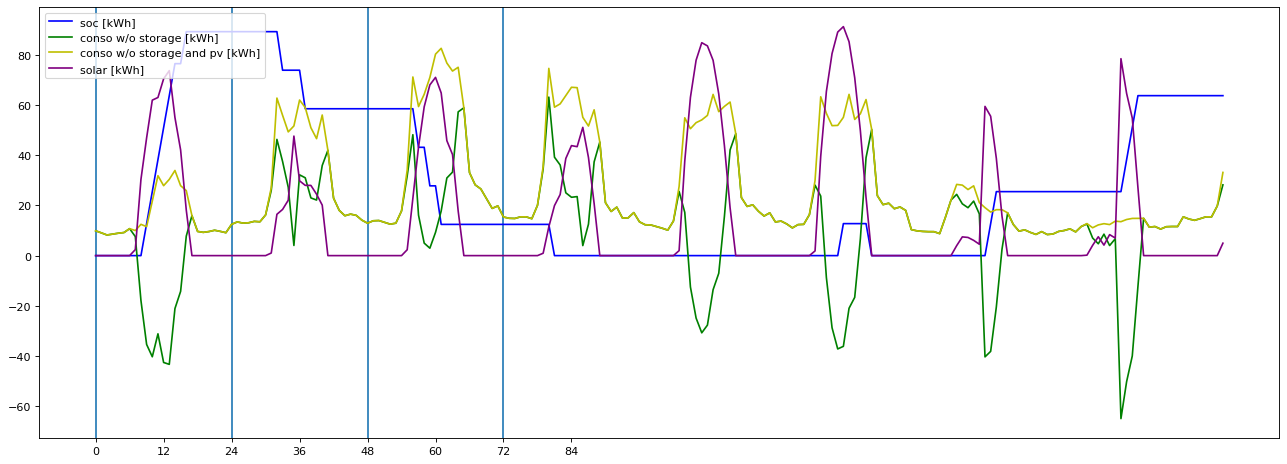

In [261]:
print_fig(soc, conso_ws, conso_wspv, solar, True, 200)

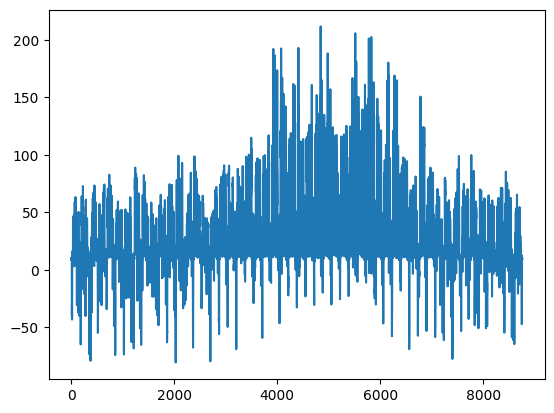

In [52]:
plt.plot(conso)

In [ ]:
for i in os.listdir('./weights/'): #0.9 #mask 0.7
    if 'mask' in i:
        if i.endswith('.zip'):
            print(i)
            test_model('ppo_mask', model_path='./weights/'+i, discrete=True, customreward=False, sum_cost=True,
                cost_ESU=True, zeta=0, total_timesteps=None)
            print()


In [88]:
env.env.buildings[0].energy_simulation.solar_generation.max()

830.63

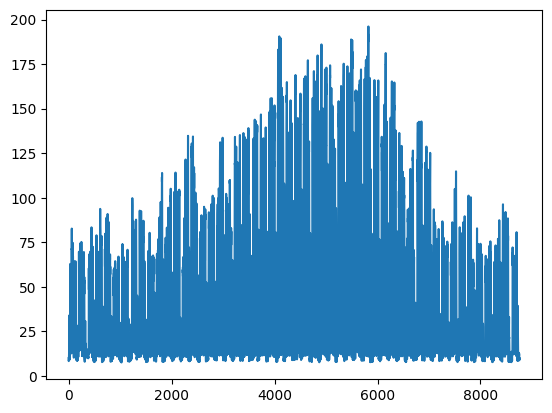

In [93]:
plt.plot(conso_wspv)

In [89]:
conso_wspv.max()

196.16289426363943

In [196]:
solar


array([0., 0., 0., ..., 0., 0., 0.])

In [201]:
x = env.env.buildings[0].pv.get_generation(solar)

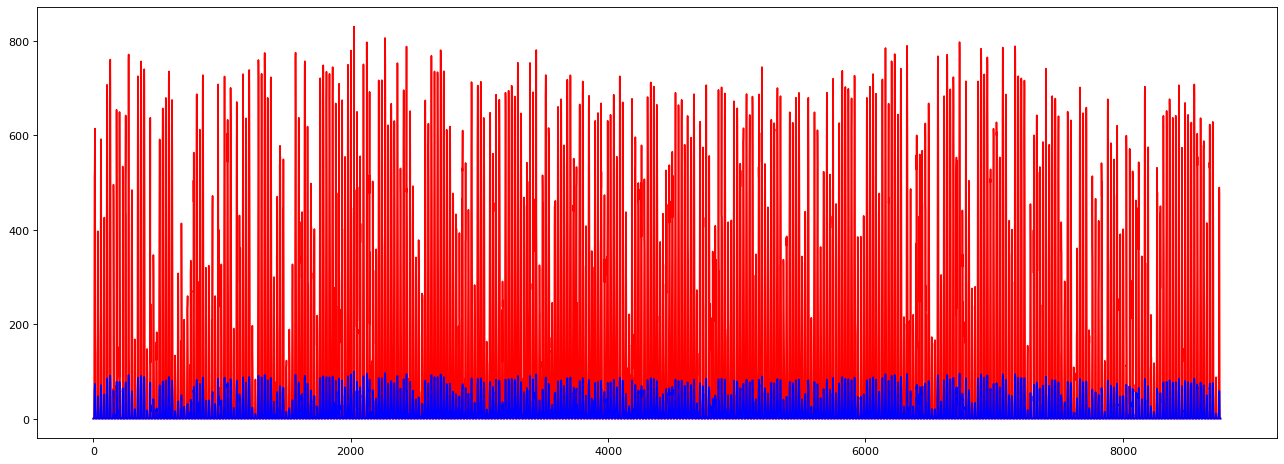

In [203]:
plt.figure(figsize=(20, 7), dpi=80)
plt.plot(range(len(solar)), solar, 'r', label="solar") # plotting t, a separately 
plt.plot(range(len(x)), x, 'b', label="x") # plotting t, a separately 

In [185]:
_ = env.reset()

In [195]:


env.step([0])[0][0]

array([  0.08333333,   1.14285714,   0.45833333,  23.51      ,
        10.63      ,  61.98072   , -40.3255385 ,   0.        ,
         0.7831798 ,   0.        ])

In [ ]:
{'month': 0,
 'day_type': 1,
 'hour': 2,
 'outdoor_dry_bulb_temperature': 3,
 'outdoor_dry_bulb_temperature_predicted_6h': 4,
 'outdoor_dry_bulb_temperature_predicted_12h': 5,
 'outdoor_dry_bulb_temperature_predicted_24h': 6,
 'outdoor_relative_humidity': 7,
 'outdoor_relative_humidity_predicted_6h': 8,
 'outdoor_relative_humidity_predicted_12h': 9,
 'outdoor_relative_humidity_predicted_24h': 10,
 'diffuse_solar_irradiance': 11,
 'diffuse_solar_irradiance_predicted_6h': 12,
 'diffuse_solar_irradiance_predicted_12h': 13,
 'diffuse_solar_irradiance_predicted_24h': 14,
 'direct_solar_irradiance': 15,
 'direct_solar_irradiance_predicted_6h': 16,
 'direct_solar_irradiance_predicted_12h': 17,
 'direct_solar_irradiance_predicted_24h': 18,
 'carbon_intensity': 19,
 'indoor_dry_bulb_temperature': 20,
 'indoor_relative_humidity': 21,
 'non_shiftable_load': 22,
 'solar_generation': 23,
 'cooling_storage_soc': 24,
 'dhw_storage_soc': 25,
 'electrical_storage_soc': 26,
 'net_electricity_consumption': 27,
 'electricity_pricing': 28}

In [231]:
if None:
    print('EOFError')

In [232]:
import plotly.express as px

df = px.data.gapminder().query("continent=='Oceania'")
df.head()

,country,continent,year,lifeExp,pop,gdpPercap,iso_alpha,iso_num
60,Australia,Oceania,1952,69.12,8691212,10039.59564,AUS,36
61,Australia,Oceania,1957,70.33,9712569,10949.64959,AUS,36
62,Australia,Oceania,1962,70.93,10794968,12217.22686,AUS,36
63,Australia,Oceania,1967,71.10,11872264,14526.12465,AUS,36
64,Australia,Oceania,1972,71.93,13177000,16788.62948,AUS,36


In [233]:
df[df['year']==1952]

,country,continent,year,lifeExp,pop,gdpPercap,iso_alpha,iso_num
60,Australia,Oceania,1952,69.12,8691212,10039.59564,AUS,36
1092,New Zealand,Oceania,1952,69.39,1994794,10556.57566,NZL,554


In [ ]:
soc, conso, conso_ws, conso_wspv, solar, day_mark=False, window=None, start=0

In [234]:
df = pd.DataFrame()
# df['time'] = [i for i in range(len(conso))]
df['conso'] = conso
df['soc'] = soc
df['conso_ws'] = conso_ws
df['conso_wspv'] = conso_wspv
df['solar'] = solar
df.head()

,time,conso,soc,conso_ws,conso_wspv,solar
0,0,9.89,0.0,9.89,9.89,0.0
1,1,9.08,0.0,9.08,9.08,0.0
2,2,8.22,0.0,8.22,8.22,0.0
3,3,8.57,0.0,8.57,8.57,0.0
4,4,8.93,0.0,8.93,8.93,0.0


In [249]:
fig = px.line(df, x="time", y="conso")
fig.add_vline(x=24)
fig.write_html('test.html')

In [250]:
def fig_plot(df, show=True, write=False):
    """
    write(str): path/name.html
    """
    fig = px.line(df, x="time", y=["conso", 'soc', 'conso_ws', 'conso_wspv', 'solar'])
    if day_mark:
        for h in [hour for hour in df['time'] if hour%24==0]:
            fig.add_vline(x=h)
    if show:
        fig.show()
    if write:
        fig.write_html(path)

In [257]:
df

,time,conso,soc,conso_ws,conso_wspv,solar
0,0,9.89,0.000000,9.89,9.89,0.0
1,1,9.08,0.000000,9.08,9.08,0.0
2,2,8.22,0.000000,8.22,8.22,0.0
3,3,8.57,0.000000,8.57,8.57,0.0
4,4,8.93,0.000000,8.93,8.93,0.0
...,...,...,...,...,...,...
8755,8755,9.37,38.255844,9.37,9.37,0.0
8756,8756,10.13,38.255844,10.13,10.13,0.0
8757,8757,10.17,38.255844,10.17,10.17,0.0
8758,8758,9.51,38.255844,9.51,9.51,0.0


In [260]:
env.env.buildings[0].dhw_storage.efficiency

0.9486832980505138

In [ ]:
-e**(i)